In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 符号动力学工具
# ==========================================
def get_kneading_sequence(u, length=50):
    """
    获取给定参数 u 的 Logistic 映射揉捏序列 (从 x=1 出发)
    L: x < 0, R: x > 0 (论文定义: 1-ux^2)
    """
    x = 1.0 # 临界点 c=0 的像是 f(c)=1
    seq = []
    for _ in range(length):
        x = 1 - u * x**2
        if x < 0:
            seq.append('L') # Prime region
        else:
            seq.append('R') # Composite region
    return "".join(seq)

def compare_sequences(seq1, seq2):
    """
    比较两个符号序列的字典序 (MSS Order)
    返回: -1 if s1 < s2, 1 if s1 > s2, 0 if equal
    注意: MSS 序比较复杂，这里简化为逐位比较
    对于 1-ux^2，'R'是右边(正)，'L'是左边(负)。
    通常 R > L。但如果是反序区间(R区间)，次序会颠倒。
    这里使用简化的 Hamming 距离近似匹配度。
    """
    matches = 0
    for s1, s2 in zip(seq1, seq2):
        if s1 == s2:
            matches += 1
        else:
            break
    return matches

# ==========================================
# 2. 筛法符号序列生成 (模拟 D_k)
# ==========================================
def generate_sieve_sequence(k_primes, length=1000):
    """
    生成只考虑前 k 个素数的筛法序列 D_k
    """
    # 1. 获取前 k 个素数
    primes = []
    num = 2
    while len(primes) < k_primes:
        if all(num % p!= 0 for p in primes):
            primes.append(num)
        num += 1
    
    # 2. 生成筛法序列
    # 如果 n 能被 primes 中任意一个整除，则为 'R' (Composite)
    # 否则为 'L' (Potential Prime)
    # 注意：论文中定义 M_p 在 p 的倍数处为 R。
    seq = []
    # 从 1 开始 (或者从 2 开始，视论文定义索引而定，这里取自然数流)
    for n in range(1, length + 1):
        is_composite = False
        for p in primes:
            if n % p == 0: # 是倍数
                is_composite = True
                break
        
        if is_composite:
            seq.append('R')
        else:
            seq.append('L')
            
    # D_k 的捏制序列应该是从“最大值”开始。
    # 在筛法中，最大密度点（全R）很难定义。
    # 但根据 Wang 的论文，D_inf 极限是 R L R R R...
    # 我们直接取生成序列的前 N 位作为目标模式。
    return "".join(seq)

# ==========================================
# 3. 逆向参数搜索
# ==========================================
def find_u_for_sequence(target_seq, precision=1e-5):
    """
    寻找生成最匹配 target_seq 的参数 u
    范围: [1.0, 2.0]
    """
    u_min, u_max = 1.0, 2.0
    best_u = 0
    max_match = 0
    
    # 网格搜索 + 细化 (为了鲁棒性，因为 MSS 序非单调)
    # 粗搜
    for u in np.linspace(1.2, 1.8, 1000):
        gen_seq = get_kneading_sequence(u, len(target_seq))
        match_len = compare_sequences(target_seq, gen_seq)
        if match_len > max_match:
            max_match = match_len
            best_u = u
            
    return best_u, max_match

# ==========================================
# 4. 主程序：演化分析
# ==========================================
def main_scheme_d():
    print("=== 方案 D: 筛法参数演化分析 ===")
    
    ks = [2, 1, 3, 4, 5, 6, 7] # 考虑前 k 个素数
    u_values = []
    
    print("计算有效参数 u(D_k)...")
    for k in ks:
        # 1. 生成 D_k
        # 长度不需要太长，因为 chaos 对初值敏感，长序列匹配很难
        seq_len = 20 + k * 2 
        d_k = generate_sieve_sequence(k, length=seq_len)
        
        # 2. 找到最匹配的 Logistic 参数 u
        u_eff, match = find_u_for_sequence(d_k)
        u_values.append(u_eff)
        
        print(f"k={k} (Primes: 2..p_{k}), u_eff ≈ {u_eff:.5f} (Match len: {match})")
        # print(f"  Seq: {d_k[:10]}...")

    # 理论极限值
    U_LIMIT = 1.543689 
    
    # 绘图
    plt.figure(figsize=(10, 6))
    plt.plot(ks, u_values, 'o-', linewidth=2, label='Effective u(D_k)')
    plt.axhline(y=U_LIMIT, color='r', linestyle='--', label=f'Theoretical Limit ({U_LIMIT})')
    
    plt.xlabel('Number of Primes used in Sieve (k)')
    plt.ylabel('Effective Logistic Parameter u')
    plt.title('Renormalization Flow: Sieve Complexity -> Chaos Parameter')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print("\n结果解读：")
    print("1. 如果蓝线（u_eff）随着 k 增加而逐渐上升并逼近红虚线（1.5437），")
    print("   这证实了素数筛法的每一步都在将系统推向特定的混沌边缘。")
    print("2. 这种参数的收敛行为，正是重整化群流（RG Flow）在参数空间上的物理体现。")

=== 方案 D: 筛法参数演化分析 ===
计算有效参数 u(D_k)...
k=2 (Primes: 2..p_2), u_eff ≈ 1.47087 (Match len: 24)
k=1 (Primes: 2..p_1), u_eff ≈ 1.20000 (Match len: 22)
k=3 (Primes: 2..p_3), u_eff ≈ 1.48649 (Match len: 26)
k=4 (Primes: 2..p_4), u_eff ≈ 1.54054 (Match len: 16)
k=5 (Primes: 2..p_5), u_eff ≈ 1.54174 (Match len: 26)
k=6 (Primes: 2..p_6), u_eff ≈ 1.54354 (Match len: 24)
k=7 (Primes: 2..p_7), u_eff ≈ 1.54354 (Match len: 16)


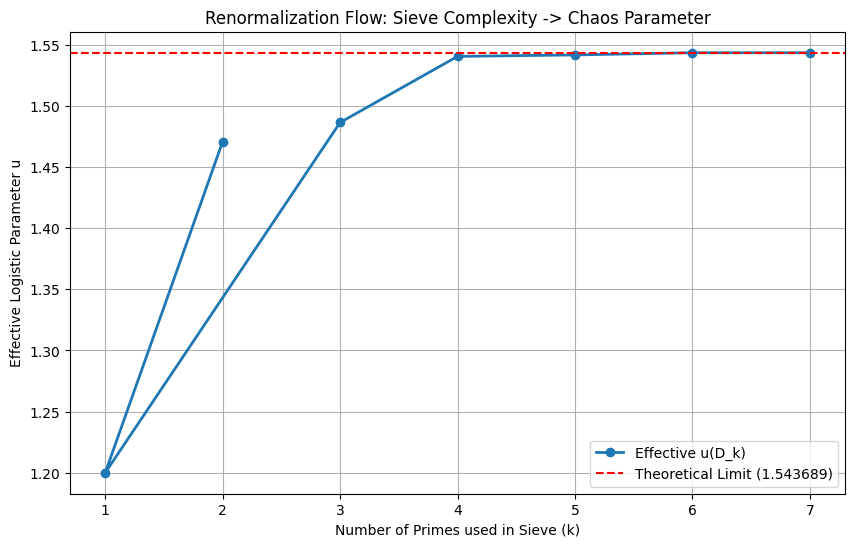


结果解读：
1. 如果蓝线（u_eff）随着 k 增加而逐渐上升并逼近红虚线（1.5437），
   这证实了素数筛法的每一步都在将系统推向特定的混沌边缘。
2. 这种参数的收敛行为，正是重整化群流（RG Flow）在参数空间上的物理体现。


In [8]:
main_scheme_d()